In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# batch operation usng tensor slice
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = K.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = K.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = K.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = K.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

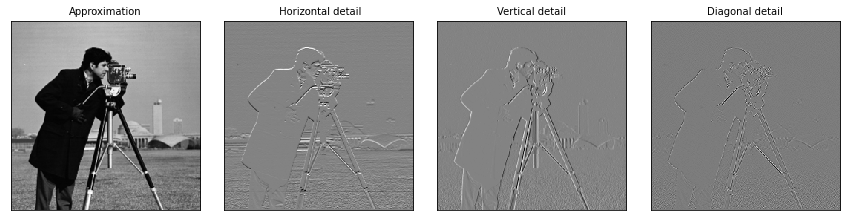

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


# Load image
original = pywt.data.camera()


# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'haar')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [4]:
original.shape

(512, 512)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


def WaveletTransform(batch, fltr='haar'):
    (n,w,h) = batch.shape 
    
    LL = torch.tensor([],dtype=torch.float32)
    LH = torch.tensor([],dtype=torch.float32)
    HL = torch.tensor([],dtype=torch.float32)
    HH = torch.tensor([],dtype=torch.float32)
    
    for batch_image in batch:
    
        batch_image = batch_image.view((w,h))
        coeffs2 = pywt.dwt2(batch_image, fltr)
        ll, (lh, hl, hh) = coeffs2
        
        #HAAR
        if(fltr=='haar'):    
            ll = torch.tensor(ll,dtype=torch.float32)
            hl = torch.tensor(hl,dtype=torch.float32)
            lh = torch.tensor(lh,dtype=torch.float32)
            hh = torch.tensor(hh,dtype=torch.float32)
        
        #DB3/BIOR1.3
        if(fltr=='db3' or fltr=='bior1.3'):
            ll = torch.tensor(ll[1:-1,1:-1],dtype=torch.float32)
            hl = torch.tensor(hl[1:-1,1:-1],dtype=torch.float32)
            lh = torch.tensor(lh[1:-1,1:-1],dtype=torch.float32)
            hh = torch.tensor(hh[1:-1,1:-1],dtype=torch.float32)

        #BIOR3.5
        if(fltr=='bior3.5'):
            ll = torch.tensor(ll[3:-2,3:-2],dtype=torch.float32)
            hl = torch.tensor(hl[3:-2,3:-2],dtype=torch.float32)
            lh = torch.tensor(lh[3:-2,3:-2],dtype=torch.float32)
            hh = torch.tensor(hh[3:-2,3:-2],dtype=torch.float32)
            
        #SYM5
        if(fltr=='sym5'):
            ll = torch.tensor(ll[2:-2,2:-2],dtype=torch.float32)
            hl = torch.tensor(hl[2:-2,2:-2],dtype=torch.float32)
            lh = torch.tensor(lh[2:-2,2:-2],dtype=torch.float32)
            hh = torch.tensor(hh[2:-2,2:-2],dtype=torch.float32)

        (new_w,new_h) = ll.shape

        ll = ll.view((1,new_w,new_h))
        hl = hl.view((1,new_w,new_h))
        lh = lh.view((1,new_w,new_h))
        hh = hh.view((1,new_w,new_h))
        
        LL = torch.cat((LL,ll))
        HL = torch.cat((HL,hl))
        LH = torch.cat((LH,lh))
        HH = torch.cat((HH,hh))
    
    return LL,LH,HL,HH

In [6]:
def Wavelet(batch_image, fltr='haar'):
    # make channel first image
#     batch_image = K.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = (batch_image[:,0,:,:]).cpu()
    g = (batch_image[:,1,:,:]).cpu()
    b = (batch_image[:,2,:,:]).cpu()

    # level 1 decomposition
    r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH = WaveletTransform(r,fltr)
    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH = WaveletTransform(g,fltr)
    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH = WaveletTransform(b,fltr)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    decom_level_1 = torch.stack(wavelet_data, axis=1).cuda()

    # level 2 decomposition
    r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2 = WaveletTransform(r_wavelet_LL,fltr)
    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2 = WaveletTransform(g_wavelet_LL,fltr)
    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2 = WaveletTransform(b_wavelet_LL,fltr)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    decom_level_2 = torch.stack(wavelet_data_l2, axis=1).cuda()

    # level 3 decomposition
    r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3 = WaveletTransform(r_wavelet_LL2,fltr)
    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3 = WaveletTransform(g_wavelet_LL2,fltr)
    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3 = WaveletTransform(b_wavelet_LL2,fltr)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    decom_level_3 = torch.stack(wavelet_data_l3, axis=1).cuda()

    # level 4 decomposition
    r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4 = WaveletTransform(r_wavelet_LL3,fltr)
    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4 = WaveletTransform(g_wavelet_LL3,fltr)
    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4 = WaveletTransform(b_wavelet_LL3,fltr)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    decom_level_4 = torch.stack(wavelet_data_l4, axis=1).cuda()
#     transform_batch_l4 = K.stack(wavelet_data_l4, axis=1)


#     decom_level_1 = K.permute_dimensions(transform_batch, [0, 2, 3, 1])
#     decom_level_2 = K.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
#     decom_level_3 = K.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
#     decom_level_4 = K.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])

#     print(decom_level_1.shape,decom_level_2.shape,decom_level_3.shape,decom_level_4.shape)
    
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]

def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [7]:
# img_batch = torch.zeros((1, 3, 224, 224))
# tmp = Wavelet(img_batch, 'sym5')
# tmp[0].shape, tmp[1].shape, tmp[2].shape, tmp[3].shape

In [8]:
import torch
import torch.nn as nn

img_batch = torch.ones((5,3,224,224))
# print(img_batch.dtype)
# r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH = WaveletTransform(img_batch)
# print(r_wavelet_LL)
# print(r_wavelet_HH)
# x = Wavelet(img_batch)

In [9]:
class Wavelet_CNN(nn.Module):
    def __init__(self):
        super(Wavelet_CNN, self).__init__()
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.conv_1 = nn.Conv2d(12, 64, 3, padding=(1,1))
        self.norm_1 = nn.BatchNorm2d(64)


        self.conv_1_2 = nn.Conv2d(64, 64, 3, stride=2, padding=(1,1))
        self.norm_1_2 = nn.BatchNorm2d(64)

        # level two decomposition starts
        self.conv_a = nn.Conv2d(12, 64, 3, padding=(1,1))
        self.norm_a = nn.BatchNorm2d(64)


        # concate level one and level two decomposition
        self.conv_2 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.norm_2 = nn.BatchNorm2d(128)


        self.conv_2_2 = nn.Conv2d(128, 128, 3, stride=2, padding=(1,1))
        self.norm_2_2 = nn.BatchNorm2d(128)    


        # level three decomposition starts 
        self.conv_b = nn.Conv2d(12, 64, 3, padding=(1,1))
        self.norm_b = nn.BatchNorm2d(64)

        self.conv_b_2 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.norm_b_2 = nn.BatchNorm2d(128)

        # concate level two and level three decomposition 
        self.conv_3 = nn.Conv2d(256, 256, 3, padding=(1,1))
        self.norm_3 = nn.BatchNorm2d(256)

        self.conv_3_2 = nn.Conv2d(256, 256, 3, stride=2, padding=(1,1))
        self.norm_3_2 = nn.BatchNorm2d(256)

        # level four decomposition start
        self.conv_c = nn.Conv2d(12, 64, 3, padding=(1,1))
        self.norm_c = nn.BatchNorm2d(64)

        self.conv_c_2 = nn.Conv2d(64, 256, 3, padding=(1,1))
        self.norm_c_2 = nn.BatchNorm2d(256)

        self.conv_c_3 = nn.Conv2d(256, 256, 3, padding=(1,1))
        self.norm_c_3 = nn.BatchNorm2d(256)


        # concate level level three and level four decomposition
        self.conv_4 = nn.Conv2d(512, 256, 3, padding=(1,1))
        self.norm_4 = nn.BatchNorm2d(256)

        self.conv_4_2 = nn.Conv2d(256, 256, 3, stride=2, padding=(1,1))
        self.norm_4_2 = nn.BatchNorm2d(256)

        self.conv_5_1 = nn.Conv2d(256, 128, 3, padding=(1,1))
        self.norm_5_1 = nn.BatchNorm2d(128)

        self.pool_5_1 = nn.AvgPool2d(7, stride=1, padding=(3,3))

        self.fc_5 = nn.Linear(6272, 2048)
        self.norm_5 = nn.BatchNorm1d(2048)
        self.drop_5 = nn.Dropout(p=0.5)

        self.fc_6 = nn.Linear(2048, 2048)
        self.norm_6 = nn.BatchNorm1d(2048)
        self.drop_6 = nn.Dropout(p=0.5)

        self.output = nn.Linear(2048, 11)
        
    def forward(self, x, fltr='haar'):
        x_l1, x_l2, x_l3, x_l4 = Wavelet(x, fltr)
        
        # level one decomposition starts
        out_l1 = self.conv_1(x_l1)
        out_l1 = self.norm_1(out_l1)
        out_l1 = self.relu(out_l1)
        
        out_l1 = self.conv_1_2(out_l1)
        out_l1 = self.norm_1_2(out_l1)
        out_l1 = self.relu(out_l1)
        
        # level two decomposition starts
        out_a = self.conv_a(x_l2)
        out_a = self.norm_a(out_a)
        out_a = self.relu(out_a)
        
        # concate level one and level two decomposition
        cat_l2 = torch.cat((out_l1, out_a), dim=1)
        out_l2 = self.conv_2(cat_l2)
        out_l2 = self.norm_2(out_l2)
        out_l2 = self.relu(out_l2)
        
        out_l2 = self.conv_2_2(out_l2)
        out_l2 = self.norm_2_2(out_l2)
        out_l2 = self.relu(out_l2)
        
        # level three decomposition starts 
        out_b = self.conv_b(x_l3)
        out_b = self.norm_b(out_b)
        out_b = self.relu(out_b)
        
        out_b = self.conv_b_2(out_b)
        out_b = self.norm_b_2(out_b)
        out_b = self.relu(out_b)

        # concate level two and level three decomposition 
        cat_l3 = torch.cat((out_l2, out_b), dim=1)
        out_l3 = self.conv_3(cat_l3)
        out_l3 = self.norm_3(out_l3)
        out_l3 = self.relu(out_l3)
        
        out_l3 = self.conv_3_2(out_l3)
        out_l3 = self.norm_3_2(out_l3)
        out_l3 = self.relu(out_l3)
        
        # level four decomposition start
        out_c = self.conv_c(x_l4)
        out_c = self.norm_c(out_c)
        out_c = self.relu(out_c)

        out_c = self.conv_c_2(out_c)
        out_c = self.norm_c_2(out_c)
        out_c = self.relu(out_c)
        
        out_c = self.conv_c_3(out_c)
        out_c = self.norm_c_3(out_c)
        out_c = self.relu(out_c)
        
        # concate level three and level four decomposition 
        cat_l4 = torch.cat((out_l3, out_c), dim=1)
        out_l4 = self.conv_4(cat_l4)
        out_l4 = self.norm_4(out_l4)
        out_l4 = self.relu(out_l4)
        
        out_l4 = self.conv_4_2(out_l4)
        out_l4 = self.norm_4_2(out_l4)
        out_l4 = self.relu(out_l4)
        
        out_l5 = self.conv_5_1(out_l4)
        out_l5 = self.norm_5_1(out_l5)
        out_l5 = self.relu(out_l5)
        
        out_l5 = self.pool_5_1(out_l5)
        out_l5 = out_l5.flatten(start_dim=1)
        
        
        out = self.fc_5(out_l5)
        out = self.norm_5(out)
        out = self.relu(out)
        out = self.drop_5(out)

        out = self.fc_6(out)
        out = self.norm_6(out)
        out = self.relu(out)
        out = self.drop_6(out)
        
        out = self.output(out)
#         out = self.softmax(out)

        return out

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [11]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      ])
    
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16)
    
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    
    return trainloader, testloader

In [12]:
data_dir = './KTH-TIPS2-a/'
trainloader, testloader = load_split_train_test(data_dir, .3)
print(trainloader.dataset.classes)

['aluminium_foil', 'brown_bread', 'corduroy', 'cork', 'cotton', 'cracker', 'lettuce_leaf', 'linen', 'white_bread', 'wood', 'wool']


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Wavelet_CNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-5)

In [14]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = acc * 100
#     print(y_pred_tags, y_test)
#     print(correct_pred)
#     print('Acc:',acc)
    return acc

In [15]:
epochs = 10
FILTER = 'haar'
steps = 0
running_loss = 0
print_every = 200
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(inputs, FILTER)
        
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in tqdm(testloader):
                    inputs, labels = inputs.to(device), labels.to(device)
                    out = model(inputs, FILTER)
                    batch_loss = criterion(out, labels)
                    test_loss += batch_loss.item()
                    
                    accuracy += multi_acc(out, labels)
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'haartexture.pth')

100%|██████████| 87/87 [00:32<00:00,  2.68it/s]


Epoch 1/10.. Train loss: 1.509.. Test loss: 0.861.. Test accuracy: 72.102


100%|██████████| 87/87 [00:31<00:00,  2.75it/s]


Epoch 2/10.. Train loss: 0.940.. Test loss: 0.550.. Test accuracy: 83.740


100%|██████████| 87/87 [00:35<00:00,  2.45it/s]


Epoch 3/10.. Train loss: 0.713.. Test loss: 0.411.. Test accuracy: 89.033


100%|██████████| 87/87 [00:33<00:00,  2.56it/s]


Epoch 4/10.. Train loss: 0.552.. Test loss: 0.307.. Test accuracy: 90.637


100%|██████████| 87/87 [00:37<00:00,  2.30it/s]


Epoch 5/10.. Train loss: 0.444.. Test loss: 0.271.. Test accuracy: 92.553


100%|██████████| 87/87 [00:34<00:00,  2.53it/s]


Epoch 6/10.. Train loss: 0.362.. Test loss: 0.279.. Test accuracy: 91.739


100%|██████████| 87/87 [00:33<00:00,  2.57it/s]


Epoch 7/10.. Train loss: 0.300.. Test loss: 0.210.. Test accuracy: 93.463


100%|██████████| 87/87 [00:31<00:00,  2.77it/s]


Epoch 8/10.. Train loss: 0.244.. Test loss: 0.221.. Test accuracy: 92.960


100%|██████████| 87/87 [00:36<00:00,  2.41it/s]


Epoch 9/10.. Train loss: 0.215.. Test loss: 0.173.. Test accuracy: 95.115


100%|██████████| 87/87 [00:17<00:00,  5.01it/s]


Epoch 10/10.. Train loss: 0.211.. Test loss: 0.175.. Test accuracy: 94.971


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Wavelet_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
